# Becoming a backprop ninja

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('Deep_Learning/NLP/makemore/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# Build the vocab of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_len = len(stoi)
print(itos)
print('vocab length:', vocab_len)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab length: 27


In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    return torch.tensor(X), torch.tensor(Y)

split1 = int(0.8 * len(words))
split2 = int(0.9 * len(words))
import random
random.seed(42)
random.shuffle(words)

X_train, Y_train = build_dataset(words[:split1])
X_val, Y_val = build_dataset(words[split1:split2])
X_test, Y_test = build_dataset(words[split2:])


In [152]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approx: {str(app):5s} | maxdiff: {maxdiff}')

In [153]:
# Define the model
emb_size = 10
hidden_size = 64

# Initialise parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_len, emb_size), generator=g)
# Layer 1
W1 = torch.randn((emb_size*block_size, hidden_size), generator=g) * (5/3)/((emb_size*block_size)**0.5)
b1 = torch.randn(hidden_size, generator=g) * 0.1 # No need for bias if using batchnorm
# Layer 2
W2 = torch.randn((hidden_size, vocab_len), generator=g) * 0.1
b2 = torch.randn(vocab_len, generator=g) * 0.1
# Batchnorm parameters
bngain = torch.randn((1, hidden_size))*0.1 + 1.0
bnbias = torch.randn((1, hidden_size))*0.1
# bnmean_running = torch.zeros((1, hidden_size))
# bnstd_running = torch.ones((1, hidden_size))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True


# def batchnorm(x, eval=False):
#     global bnmean_running, bnstd_running

#     if eval:
#         mean = bnmean_running
#         std = bnstd_running
#     else:
#         mean = x.mean(dim=0, keepdim=True)
#         std = (x.std(dim=0, keepdim=True) + 1e-8)
#         bnmean_running = 0.999 * bnmean_running + 0.001 * mean
#         bnstd_running = 0.999 * bnstd_running + 0.001 * std
#     normed = (x - mean) / std
#     return normed * bngain + bnbias

# def model(x, eval=False):
#     assert x.dim() == 2, f'expected 2D input, got {x.dim()}D'
#     emb = C[x].view(len(x), -1) # embedded input
#     h_pre = emb @ W1 # hidden layer, pre activation func
#     h_bn = batchnorm(h_pre, eval) # batchnorm
#     h = torch.tanh(h_bn) # hidden layer, post activation func
#     logits = h @ W2 + b2 # output layer
#     return logits


# # Initialise trackers
# train_lossi = []
# val_lossi = []
# stepi = []
# evali = []

In [154]:
batch_size = 32
n = batch_size
idx = torch.randint(0, len(X_train), (n,), generator=g)
Xb, Yb = X_train[idx], Y_train[idx]

In [155]:
# Forward pass, in small steps

# Embedding Layer 
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

# Linear Layer 1
hprebn = embcat @ W1 + b1

# Batchnorm
bnmeani = 1/n*hprebn.sum(dim=0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*bndiff2.sum(dim=0, keepdim=True) # Using Bessel's correction (dividing by n-1 instead of n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact)

# Linear Layer 2
logits = h @ W2 + b2

# Cross-entropy loss
logit_maxes = logits.max(dim=1, keepdim=True).values
norm_logits = logits - logit_maxes # Subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(dim=1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact,
          bnraw, bnvar_inv, bnvar, bndiff2, bndiff, bnmeani,
          hprebn, embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3362, grad_fn=<NegBackward0>)

In [146]:
bnmeani.shape, hprebn.shape, bndiff.shape

(torch.Size([1, 64]), torch.Size([32, 64]), torch.Size([32, 64]))

In [156]:
dlogprobs =  torch.zeros_like(logprobs)
dlogprobs[range(n),Yb] = -1.0/n
dprobs = 1.0/probs * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)
dcounts = counts_sum_inv * dprobs 
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += dcounts_sum.expand(counts.shape)
dnorm_logits = counts * dcounts
dlogit_maxes = -dnorm_logits.sum(dim=1, keepdim=True).expand(logit_maxes.shape)
dlogits = dnorm_logits
dlogits[range(n), logits.max(dim=1).indices] += dlogit_maxes.squeeze(1)
dh = dlogits @ W2.t()
dW2 = (h.t() @ dlogits)
db2 = dlogits.sum(dim=0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(dim=0, keepdim=True)
dbnbias = dhpreact.sum(dim=0, keepdim=True)
dbnraw = (bngain * dhpreact)
dbnvar_inv = (bndiff * dbnraw).sum(dim=0, keepdim=True)
dbnvar = -0.5*(bnvar+1e-5)**-1.5 * dbnvar_inv
dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar
dbndiff = bnvar_inv * dbnraw
dbndiff += 2 * bndiff * dbndiff2
dbnmeani = -dbndiff.sum(dim=0, keepdim=True)
dhprebn = dbndiff
dhprebn += 1/n * torch.ones_like(hprebn) * dbnmeani
dembcat = dhprebn @ W1.t()


cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
# cmp('W1', dW1, W1)
# cmp('b1', db1, b1)
# cmp('emb', demb, emb)
# cmp('C', dC, C)

logprobs        | exact: True  | approx: True  | maxdiff: 0.0
probs           | exact: True  | approx: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approx: True  | maxdiff: 0.0
counts_sum      | exact: True  | approx: True  | maxdiff: 0.0
counts          | exact: True  | approx: True  | maxdiff: 0.0
norm_logits     | exact: False | approx: True  | maxdiff: 6.51925802230835e-09
logit_maxes     | exact: True  | approx: True  | maxdiff: 0.0
logits          | exact: True  | approx: True  | maxdiff: 0.0
h               | exact: True  | approx: True  | maxdiff: 0.0
W2              | exact: True  | approx: True  | maxdiff: 0.0
b2              | exact: True  | approx: True  | maxdiff: 0.0
hpreact         | exact: True  | approx: True  | maxdiff: 0.0
bngain          | exact: True  | approx: True  | maxdiff: 0.0
bnbias          | exact: True  | approx: True  | maxdiff: 0.0
bnraw           | exact: True  | approx: True  | maxdiff: 0.0
bnvar_inv       | exact: True  | approx: True  | maxd

In [131]:
dbndiff, bndiff.grad

(tensor([[-7.6108e-05,  1.2347e-04,  1.9981e-03,  ...,  1.6617e-05,
          -2.3287e-04,  4.0592e-04],
         [-4.5307e-05,  2.0803e-04, -2.6765e-03,  ..., -3.8086e-04,
           1.1760e-03,  2.9721e-03],
         [ 2.4925e-04, -7.8074e-04, -1.6765e-03,  ...,  1.4188e-03,
          -3.4100e-03, -3.8357e-04],
         ...,
         [ 1.6317e-04, -2.0433e-05,  1.4156e-03,  ...,  5.9098e-05,
          -3.3875e-03,  9.1141e-04],
         [ 1.7521e-04,  9.9951e-04,  9.7441e-04,  ...,  1.6083e-03,
           4.1965e-04, -1.2777e-04],
         [-5.7270e-04, -2.4560e-04, -3.6565e-03,  ..., -6.9673e-04,
           1.1211e-03,  1.8175e-03]], grad_fn=<AddBackward0>),
 tensor([[-2.3463e-04,  5.3012e-04,  1.3891e-03,  ...,  6.4014e-04,
          -8.7623e-04,  7.4512e-04],
         [-2.0382e-04,  6.1469e-04, -3.2855e-03,  ...,  2.4266e-04,
           5.3262e-04,  3.3113e-03],
         [ 9.0736e-05, -3.7409e-04, -2.2855e-03,  ...,  2.0424e-03,
          -4.0533e-03, -4.4368e-05],
         ...,
 

In [69]:
# def eval(X, Y):
#     logits = model(X, eval=True)
#     loss = F.cross_entropy(logits, Y)
#     return loss


def train(learning_rate=0.01, epochs = 200000, batch_size=32, step=0, eval_every=1000):
    global bnmean_running_track, bnstd_running_track
    for epoch in range(epochs):
        # build minibatches
        idxs = torch.randint(0, X_train.shape[0], (batch_size,), generator=g).to(device)
        Xmb, Ymb = X_train[idxs], Y_train[idxs]

        # forward pass
        logits = model(Xmb)
        loss = F.cross_entropy(logits, Ymb)

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = learning_rate if epochs < 100000 else learning_rate/10.0
        for p in parameters: 
            p.data += -lr * p.grad

        if epoch % eval_every == 0:
            with torch.no_grad():
                val_loss = eval(X_val, Y_val)
                evali.append(step+epoch)
                val_lossi.append(val_loss.log10().item())

        stepi.append(step+epoch)
        train_lossi.append(loss.log10().item())

        bnmean_running_track.append(bnmean_running[0,0].item())
        bnstd_running_track.append(bnstd_running[0,0].item())

    

    return loss.item()

In [70]:
bnmean_running_track = []
bnstd_running_track = []

last train loss: 0.3214015066623688


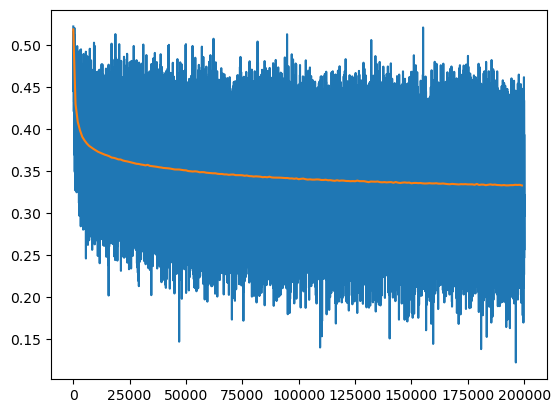

In [71]:
step = stepi[-1] if len(stepi) > 0 else 0
train(learning_rate=0.1, epochs=200000, batch_size=32, step=step)
plt.plot(stepi, train_lossi)
plt.plot(evali, val_lossi)
print(f"last train loss: {train_lossi[-1]}")

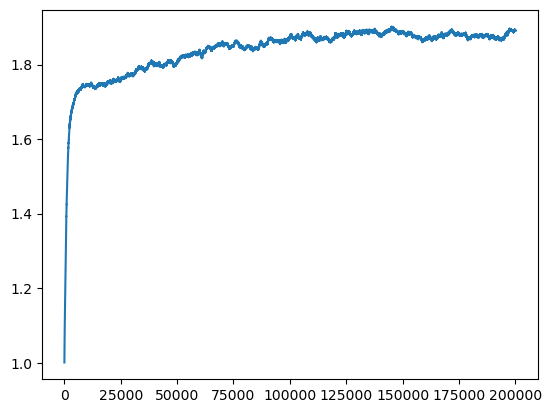

In [72]:
# plt.plot(bnmean_running_track)
plt.plot(bnstd_running_track)
plt.show()

In [61]:
print(f"train loss: {eval(X_train, Y_train)}")
print(f"val loss: {eval(X_val, Y_val)}")

train loss: 2.130506992340088
val loss: 2.1533138751983643


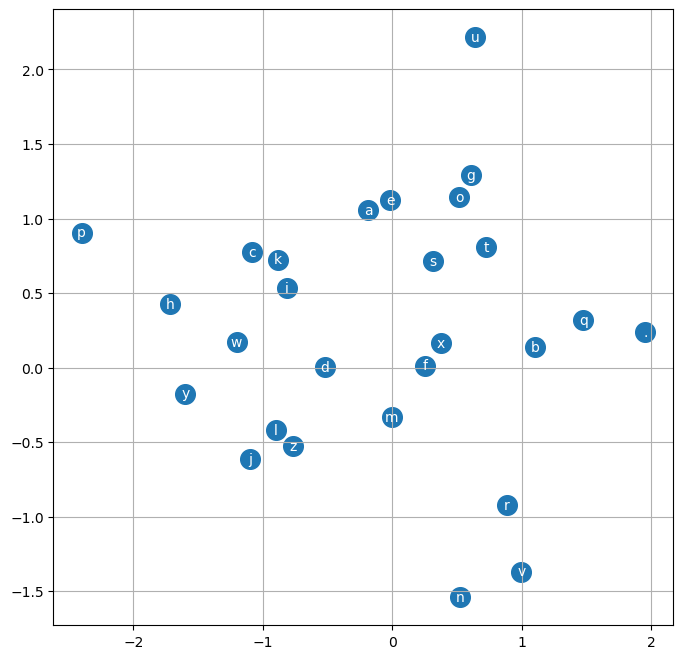

In [79]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [87]:
# Sampling from the model

g = torch.Generator().manual_seed(42)

for _ in range (20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]), eval=True)
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    print(''.join(itos[i] for i in out))

anuseen.
tis.
mari.
nedyn.
shan.
silayley.
kemarce.
man.
epiacelle.
jamel.
angon.
jordon.
kalla.
mari.
yana.
cvahia.
achance.
tian.
tiyan.
mar.
